In [1]:
import os
import warnings
import random
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import AutoTokenizer, TFAutoModel
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## TPU Config

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Configuration

In [3]:
SEED = 1191
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
seed_everything(SEED)

LABEL_SMOOTHING = False
FOCAL_LOSS = False
EPOCHS = 2
BATCH_SIZE = 20 * strategy.num_replicas_in_sync
MAX_LEN = 256
INCLUDE_TRANSLATED_DATA = False


# Conflict check
if (LABEL_SMOOTHING==True) and (FOCAL_LOSS==True):
    raise ValueError
    
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

## Helper Functions

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [6]:
def label_smoothing(y_true, y_pred):
    
     return tf.keras.losses.binary_crossentropy(y_true,y_pred, label_smoothing=0.1)

In [7]:
def build_model(transformer, model_type, loss='binary_crossentropy', max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(cls_token)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Dropout(0.15)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    out = Dense(1, activation='sigmoid')(x1)
    
    model = Model(inputs=input_word_ids, outputs=out)
    if model_type == 'roberta':
        model.compile(Adam(lr=1e-5), loss=loss, metrics=['accuracy'])
    elif (model_type == 'bert-base-uncased') or (model_type == 'bert-base-cased'):
        model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
        
    return model

## Create fast tokenizer

In [8]:
# First load the real tokenizer
bert_uncased_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
bert_cased_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
roberta_tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')


## Load text data into memory

In [9]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid_en = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')

test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

## Fast encode

In [10]:
%%time

x_train_uncased = regular_encode(train1.comment_text.astype(str), bert_uncased_tokenizer, maxlen=MAX_LEN)
x_valid_en_uncased = regular_encode(valid_en.comment_text_en.astype(str), bert_uncased_tokenizer, maxlen=MAX_LEN)
x_train_cased = regular_encode(train1.comment_text.astype(str), bert_cased_tokenizer, maxlen=MAX_LEN)
x_valid_en_cased = regular_encode(valid_en.comment_text_en.astype(str), bert_cased_tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, roberta_tokenizer, maxlen=192)
x_test = regular_encode(test.content.values, roberta_tokenizer, maxlen=192)
x_test1_uncased = regular_encode(test1.content_en.astype(str), bert_uncased_tokenizer, maxlen=MAX_LEN)
x_test2_uncased = regular_encode(test2.translated.astype(str), bert_uncased_tokenizer, maxlen=MAX_LEN)
x_test1_cased = regular_encode(test1.content_en.astype(str), bert_cased_tokenizer, maxlen=MAX_LEN)
x_test2_cased = regular_encode(test2.translated.astype(str), bert_cased_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid_en = valid_en.toxic.values
y_valid = valid.toxic.values

CPU times: user 35min 32s, sys: 3.94 s, total: 35min 36s
Wall time: 35min 35s


## Build datasets objects

In [11]:
%%time

train_dataset_uncased = (
    tf.data.Dataset
    .from_tensor_slices((x_train_uncased, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

train_dataset_cased = (
    tf.data.Dataset
    .from_tensor_slices((x_train_cased, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset_en_uncased = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_en_uncased, y_valid_en))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

valid_dataset_en_cased = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_en_cased, y_valid_en))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset_en_uncased = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1_uncased)
    .batch(BATCH_SIZE)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2_uncased)
    .batch(BATCH_SIZE)
)]

test_dataset_en_cased = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1_cased)
    .batch(BATCH_SIZE)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2_cased)
    .batch(BATCH_SIZE)
)]

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

CPU times: user 1.22 s, sys: 2.73 s, total: 3.95 s
Wall time: 6.01 s


# Focal Loss

In [12]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Load model into the TPU

In [13]:
%%time
with strategy.scope():
    bert_uncased_transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    bert_uncased_model = build_model(bert_uncased_transformer_layer, 'bert-base-uncased', focal_loss(gamma=1.5), MAX_LEN)
    bert_cased_transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-cased')
    bert_cased_model = build_model(bert_cased_transformer_layer, 'bert-base-cased', focal_loss(gamma=1.5), MAX_LEN)
    roberta_transformer_layer = TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-large')
    roberta_model = build_model(roberta_transformer_layer, 'roberta', 'binary_crossentropy', 192)
    roberta_model.load_weights('../input/pretrained-roberta/pretrained_roberta_model.h5')
bert_uncased_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 256, 768), (None, 109482240 
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 128)          196736    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 128)          0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 64)           16448

In [14]:
bert_cased_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 256, 768), (None, 108310272 
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 128)          196736    
_________________________________________________________________
dropout_78 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 128)          0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 64)           1644

In [15]:
roberta_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 192, 128)          262272    
_________________________________________________________________
dropout_156 (Dropout)        (None, 192, 128)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 192, 128)          0         
_________________________________________________________________
dropout_157 (Dropout)        (None, 192, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 192, 64)           1644

## RocAuc Callback

In [16]:
from tensorflow.keras.callbacks import Callback 

class RocAucCallback(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))
                
class RocAucCallback2(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc_1'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))

# LrScheduler

In [17]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

## Train Model

In [18]:
%%time

roc_auc = RocAucCallback(test_dataset_en_uncased, 0.9171)
roc_auc2 = RocAucCallback2(test_dataset_en_cased, 0.9189)

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

checkpoint_path = 'bert_uncased%sx%s.h5' % (SEED, MAX_LEN)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True)

train_history = bert_uncased_model.fit(
    train_dataset_uncased,
    steps_per_epoch=150,
    validation_data=valid_dataset_en_uncased,
    callbacks=[lr_schedule, roc_auc, checkpoint],
    epochs=31
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/31
150/150 [==============================] - 57s 377ms/step - auc: 0.5217 - loss: 0.0798 - val_auc: 0.5663 - val_loss: 0.0821 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/31
150/150 [==============================] - 38s 251ms/step - auc: 0.6197 - loss: 0.0451 - val_auc: 0.6914 - val_loss: 0.0587 - lr: 3.1429e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/31
150/150 [==============================] - 38s 251ms/step - auc: 0.7746 - loss: 0.0329 - val_auc: 0.8310 - val_loss: 0.0523 - lr: 5.2857e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 7.4285714285714275e-06.
Epoch 4/31
150/150 [==============================] - 38s 252ms/step - auc: 0.9087 - loss: 0.0211 - val_auc: 0.8900 - val_loss: 0.0448 - lr: 7.4286e-06

Epoch 00005: LearningRateScheduler reducing learning rate to 9.571

In [19]:
%%time

checkpoint_path2 = 'bert_cased%sx%s.h5' % (SEED, MAX_LEN)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2, save_best_only=True, save_weights_only=True)


train_history2 = bert_cased_model.fit(
    train_dataset_cased,
    steps_per_epoch=150,
    validation_data=valid_dataset_en_cased,
    callbacks=[lr_schedule, roc_auc2, checkpoint2],
    epochs=31
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/31
150/150 [==============================] - 56s 370ms/step - auc_1: 0.4993 - loss: 0.0825 - val_auc_1: 0.5602 - val_loss: 0.0796 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/31
150/150 [==============================] - 37s 248ms/step - auc_1: 0.5790 - loss: 0.0495 - val_auc_1: 0.6699 - val_loss: 0.0655 - lr: 3.1429e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/31
150/150 [==============================] - 37s 248ms/step - auc_1: 0.6982 - loss: 0.0365 - val_auc_1: 0.8171 - val_loss: 0.0588 - lr: 5.2857e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 7.4285714285714275e-06.
Epoch 4/31
150/150 [==============================] - 37s 249ms/step - auc_1: 0.8908 - loss: 0.0240 - val_auc_1: 0.9019 - val_loss: 0.0381 - lr: 7.4286e-06

Epoch 00005: LearningRateScheduler reducing learni

## Submission

In [20]:
import seaborn as sns
def plot_result(sub):
    sns.set()
    plt.hist(sub['toxic'],bins=100)
    plt.show()

ValueError: autodetected range of [nan, nan] is not finite

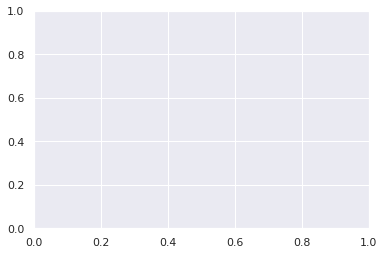

In [21]:
bert_uncased_sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
bert_uncased_sub['toxic'] = np.mean(roc_auc.test_pred, axis=0)
plot_result(bert_uncased_sub)

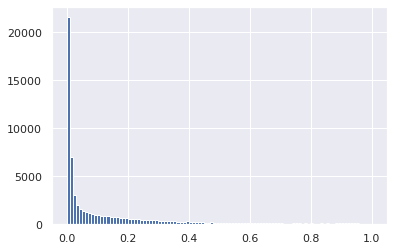

In [22]:
bert_cased_sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
bert_cased_sub['toxic'] = np.mean(roc_auc2.test_pred, axis=0)
plot_result(bert_cased_sub)

399/399 [==============================] - 63s 159ms/step


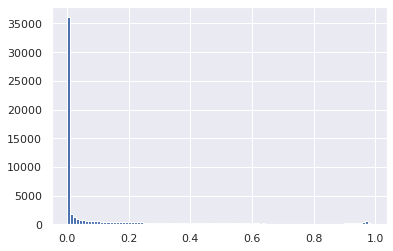

In [23]:
roberta_sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
roberta_sub['toxic'] = roberta_model.predict(test_dataset, verbose=1)
plot_result(roberta_sub)

In [24]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub['toxic'] = roberta_sub['toxic'] * 0.80 + bert_uncased_sub['toxic'] * 0.05 + bert_cased_sub['toxic'] * 0.15

In [25]:
sub.to_csv('submission.csv', index=False)

ValueError: autodetected range of [nan, nan] is not finite

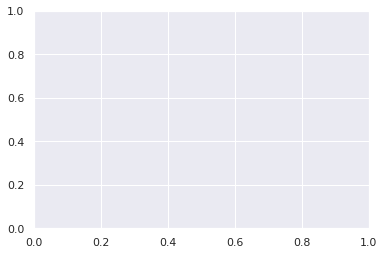

In [26]:
plot_result(sub)

In [27]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub['toxic'] = roberta_sub['toxic'] * 0.7 + bert_uncased_sub['toxic'] * 0.1 + bert_cased_sub['toxic'] * 0.2
sub.to_csv('submission2.csv', index=False)

In [28]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub['toxic'] = roberta_sub['toxic'] * 0.75 + bert_uncased_sub['toxic'] * 0.07 + bert_cased_sub['toxic'] * 0.18
sub.to_csv('submission3.csv', index=False)

# Reference
* [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)
* [inference of bert tpu model ml w/ validation](https://www.kaggle.com/abhishek/inference-of-bert-tpu-model-ml-w-validation)
* [Overview of Text Similarity Metrics in Python](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)
* [test-en-df](https://www.kaggle.com/bamps53/test-en-df)
* [val_en_df](https://www.kaggle.com/bamps53/val-en-df)
* [Jigsaw multilingual toxic - test translated](https://www.kaggle.com/kashnitsky/jigsaw-multilingual-toxic-test-translated)